<a href="https://colab.research.google.com/github/Paranoyyam/PlantVillage-Dataset-Coco/blob/main/GLCM_Classify_Plant_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<h1>GLCM Depth Classifier using LightBGM**



**For training model from scratch:**


1. Download Dependencies
2. Load Dataset from Repo
3. Setup Imports
4. Configure Dataset for Training Setup
5. Initialize Model for Training
6. Post-training Model Evaluation
7. Save Model Weights


**For evaluating Pre-trained model:**


1. Download Dependencies
2. Load Dataset from Repo
3. Setup Imports
4. Model Testing using Pre-Trained Model Weights


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **==================Download Dependencies==================**

In [2]:
!git clone https://github.com/SSSerpenttt/GLCM-Classifier.git

fatal: destination path 'GLCM-Classifier' already exists and is not an empty directory.


In [3]:
!pip install -r /content/GLCM-Classifier/requirements.txt

# **==================Load Dataset from Repo==================**

In [4]:
!git clone --branch master https://github.com/SSSerpenttt/GroupEGS-Thesis-Dataset.git

Cloning into 'GroupEGS-Thesis-Dataset'...
remote: Enumerating objects: 2608, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 2608 (delta 10), reused 0 (delta 0), pack-reused 2575 (from 1)
Receiving objects: 100% (2608/2608), 213.66 MiB | 18.45 MiB/s, done.
Resolving deltas: 100% (14/14), done.
Updating files: 100% (2546/2546), done.


# **Setup Imports**

In [4]:
import sys
from pathlib import Path

In [5]:
import tensorflow as tf
import numpy as np
import sklearn
import pandas as pd
import matplotlib
import cv2
import scipy

In [6]:
src_path = Path('/content/GLCM-Classifier/src')
if src_path.exists():
    sys.path.append(str(src_path))

from utils.data_loader import load_data
from config import Config
from glcm_model import GLCMModel

# **Configure Dataset for Training Setup**

импорт каггл проекта и преобразование в coco .json формат

In [7]:
# The following code will only execute
# successfully when compression is complete

import kagglehub

# Download latest version
path = kagglehub.dataset_download("ankosolo111/plantdiseasecocorar")

print("Path to dataset files:", path)

100%|██████████| 811M/811M [00:08<00:00, 95.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ankosolo111/plantdiseasecocorar/versions/3


In [8]:
# Create a configuration object
config = Config(
    epochs=20,
    #data_path="/content/GroupEGS-Thesis-Dataset",  # Colab path
    data_path="/root/.cache/kagglehub/datasets/ankosolo111/plantdiseasecocorar/versions/3",
)

# Load data
#data = load_data(config.data_path, include_labels=["depth-deep", "depth-shallow"])
# data = load_data(config.data_path, include_labels=[
#     "0", "1", "2", "3","4", "5","6", "7","8", "9","10", "11","12", "13","14", "15",
#     "16", "17","18", "19","20", "21","22", "23","24", "25","26", "27","28", "29","30", "31","32", "33",
#     "34", "35","36", "37" ])

data = load_data(config.data_path, include_labels= [
    "Apple___Apple_scab",
    "Apple___Black_rot",
    "Apple___Cedar_apple_rust",
    "Apple___healthy",
    "Blueberry___healthy",
    "Cherry___Powdery_mildew",
    "Cherry___healthy",
    "Corn___Cercospora_leaf_spot_Gray_leaf_spot",
    "Corn___Common_rust",
    "Corn___Northern_Leaf_Blight",
    "Corn___healthy",
    "Grape___Black_rot",
    "Grape___Esca_(Black_Measles)",
    "Grape___Leaf_blight_(Isariopsis_Leaf_Spot)",
    "Grape___healthy",
    "Orange___Haunglongbing_(Citrus_greening)",
    "Peach___Bacterial_spot",
    "Peach___healthy",
    "Pepper_bell___Bacterial_spot",
    "Pepper_bell___healthy",
    "Potato___Early_blight",
    "Potato___Late_blight",
    "Potato___healthy",
    "Raspberry___healthy",
    "Soybean___healthy",
    "Squash___Powdery_mildew",
    "Strawberry___Leaf_scorch",
    "Strawberry___healthy",
    "Tomato___Bacterial_spot",
    "Tomato___Early_blight",
    "Tomato___Late_blight",
    "Tomato___Leaf_Mold",
    "Tomato___Septoria_leaf_spot",
    "Tomato___Spider_mites_Two-spotted_spider_mite",
    "Tomato___Target_Spot",
    "Tomato___Tomato_Yellow_Leaf_Curl_Virus",
    "Tomato___Tomato_mosaic_virus",
    "Tomato___healthy"
])


train_data = data["train_data"]
val_data = data["val_data"]
test_data = data["test_data"]
print("Data loaded successfully.")

print("Sample ROIs:", train_data["rois"][:5])
print("Training Labels:", np.unique(train_data["labels"]))
print("Validation Labels:", np.unique(val_data["labels"]))
print("Test Labels:", np.unique(test_data["labels"]))

Data loaded successfully.
Sample ROIs: [[[49, 17, 166, 215]], [[2, 4, 236, 249]], [[1, 0, 251, 254]], [[20, 2, 224, 252]], [[1, 9, 255, 247]]]
Training Labels: [list(['Apple___Apple_scab']) list(['Apple___Black_rot'])
 list(['Apple___Cedar_apple_rust']) list(['Apple___healthy'])
 list(['Blueberry___healthy']) list(['Cherry___Powdery_mildew'])
 list(['Cherry___healthy'])
 list(['Corn___Cercospora_leaf_spot_Gray_leaf_spot'])
 list(['Corn___Cercospora_leaf_spot_Gray_leaf_spot', 'Corn___Cercospora_leaf_spot_Gray_leaf_spot'])
 list(['Corn___Common_rust']) list(['Corn___Northern_Leaf_Blight'])
 list(['Corn___Northern_Leaf_Blight', 'Corn___Northern_Leaf_Blight'])
 list(['Corn___healthy']) list(['Grape___Black_rot'])
 list(['Grape___Esca_(Black_Measles)'])
 list(['Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'])
 list(['Grape___healthy'])
 list(['Orange___Haunglongbing_(Citrus_greening)'])
 list(['Peach___Bacterial_spot']) list(['Peach___healthy'])
 list(['Pepper_bell___Bacterial_spot']) list(['P

/usr/local/lib/python3.11/dist-packages/numpy/lib/arraysetops.py:272: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


## **Configuration Checks**

In [9]:
import os
print(os.listdir('/root/.cache/kagglehub/datasets/ankosolo111/plantdiseasecocorar/versions/3'))  # Убедитесь, что файлы существуют

['test', 'train', 'valid']


In [10]:
print("Все ключи train_data:", train_data.keys())  # Например, может быть 'X_train', 'y_train'

Все ключи train_data: dict_keys(['images', 'labels', 'rois'])


In [11]:
# Check the keys
print("Train keys:", train_data.keys())
print("Validation keys:", val_data.keys())
print("Test keys:", test_data.keys())

# Check shapes
print("Train images shape:", train_data["images"].shape)
print("Train labels length:", len(train_data["labels"]))  # Use len() for lists
print("Train ROIs length:", len(train_data["rois"]))      # Use len() for lists

print("Validation images shape:", val_data["images"].shape)
print("Validation labels length:", len(val_data["labels"]))  # Use len() for lists
print("Validation ROIs length:", len(val_data["rois"]))      # Use len() for lists

print("Test images shape:", test_data["images"].shape)
print("Test labels length:", len(test_data["labels"]))  # Use len() for lists
print("Test ROIs length:", len(test_data["rois"]))      # Use len() for lists)

Train keys: dict_keys(['images', 'labels', 'rois'])
Validation keys: dict_keys(['images', 'labels', 'rois'])
Test keys: dict_keys(['images', 'labels', 'rois'])
Train images shape: (38004, 256, 256)
Train labels length: 38004
Train ROIs length: 38004
Validation images shape: (10858, 256, 256)
Validation labels length: 10858
Validation ROIs length: 10858
Test images shape: (5430, 256, 256)
Test labels length: 5430
Test ROIs length: 5430


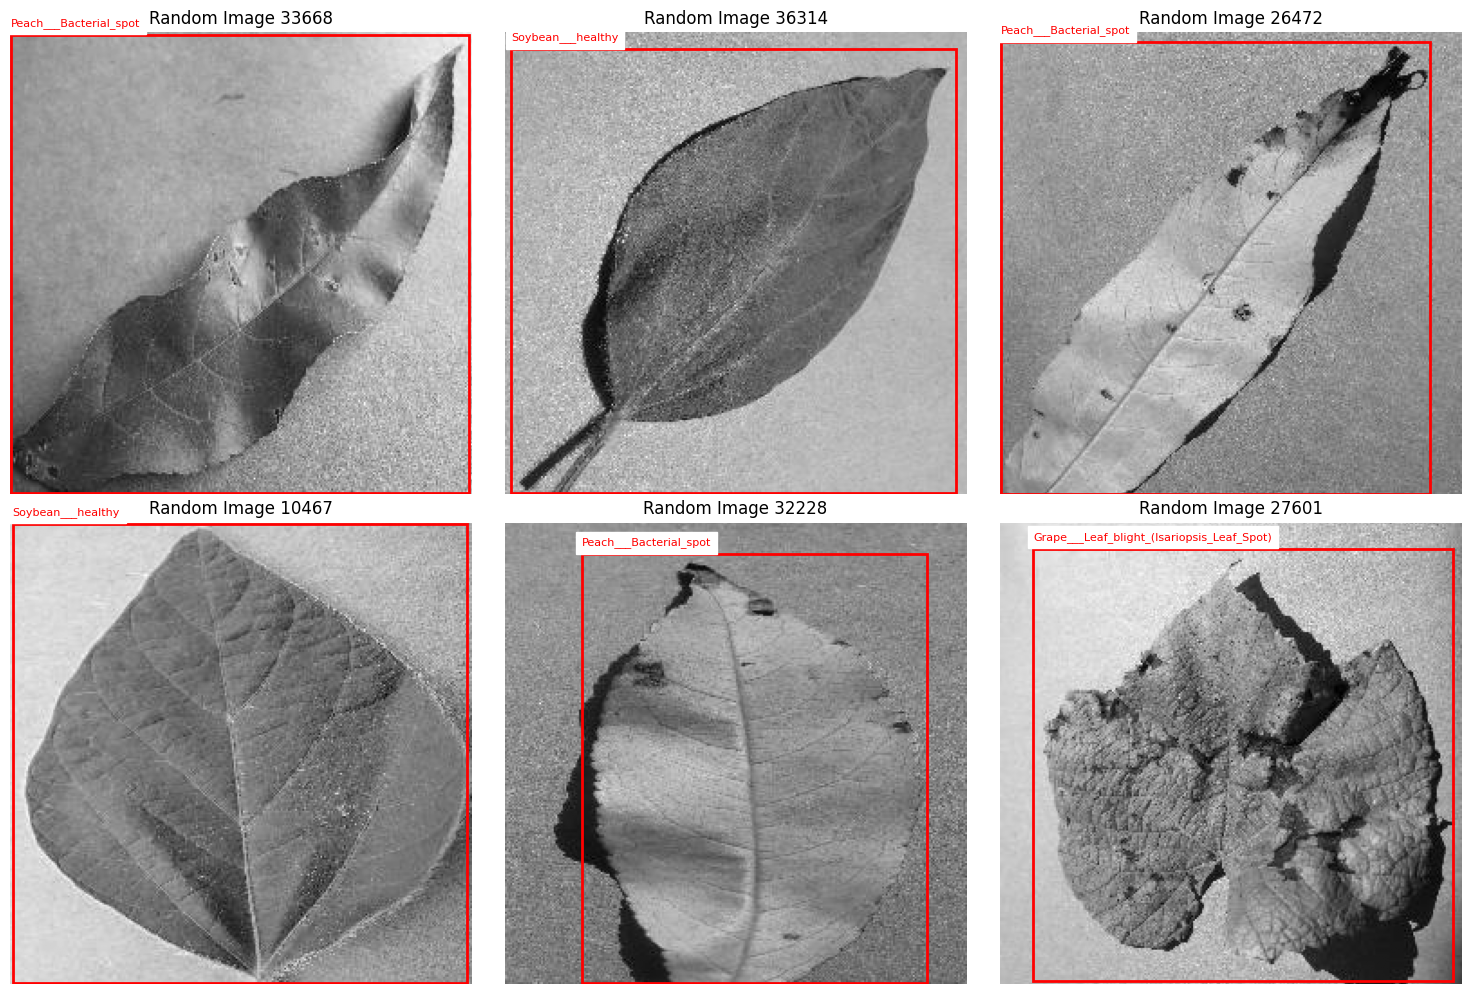

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

# Function to display an image with its ROIs and labels
def display_image_with_rois(image, rois, labels, ax):
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    for bbox, label in zip(rois, labels):
        x, y, w, h = bbox
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y - 5, label, color='red', fontsize=8, backgroundcolor='white')

# 🔢 Number of images to display (change as needed)
num_samples = 6

# Randomly select indices from the training data
num_images = len(train_data["images"])
sample_indices = random.sample(range(num_images), min(num_samples, num_images))

# Create subplots
cols = 3
rows = (len(sample_indices) + cols - 1) // cols  # ceiling division
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))

# Flatten axes if it's 2D
axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

# Display images
for i, idx in enumerate(sample_indices):
    display_image_with_rois(
        train_data["images"][idx],
        train_data["rois"][idx],
        train_data["labels"][idx],
        axes[i]
    )
    axes[i].set_title(f"Random Image {idx}")

# Hide any unused axes
for j in range(len(sample_indices), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


In [13]:
# Check the format of the labels
print("Checking label formats...")

# Convert labels to NumPy arrays
train_labels = np.array(train_data["labels"])
val_labels = np.array(val_data["labels"])

# Check the format of the labels
print("Checking label formats...")

# Check training labels
print("Training labels:")
print(f"Shape: {train_labels.shape}")
print(f"Sample: {train_labels[:5]}")  # Print the first 5 labels

# Check validation labels
print("\nValidation labels:")
print(f"Shape: {val_labels.shape}")
print(f"Sample: {val_labels[:5]}")  # Print the first 5 labels

# Check if labels are 1D or 2D
if len(train_labels.shape) > 1:
    print("\nTraining labels are 2D. You may need to flatten them.")
else:
    print("\nTraining labels are 1D. Format is correct.")

if len(val_labels.shape) > 1:
    print("Validation labels are 2D. You may need to flatten them.")
else:
    print("Validation labels are 1D. Format is correct.")

Checking label formats...
Checking label formats...
Training labels:
Shape: (38004,)
Sample: [list(['Blueberry___healthy']) list(['Soybean___healthy'])
 list(['Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'])
 list(['Tomato___Leaf_Mold']) list(['Squash___Powdery_mildew'])]

Validation labels:
Shape: (10858,)
Sample: [list(['Tomato___Bacterial_spot']) list(['Peach___Bacterial_spot'])
 list(['Tomato___Bacterial_spot']) list(['Apple___healthy'])
 list(['Orange___Haunglongbing_(Citrus_greening)'])]

Training labels are 1D. Format is correct.
Validation labels are 1D. Format is correct.


<ipython-input-13-24ce7e47ba1a>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_labels = np.array(train_data["labels"])
<ipython-input-13-24ce7e47ba1a>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val_labels = np.array(val_data["labels"])


# **Initialize Model for Training**

In [14]:
# Initialize model and data loader
model = GLCMModel(config)
print("Model configured successfully.")

Using lightgbm as the classifier.
Model configured successfully.


In [15]:
config.display()

Configuration Settings:
Dataset Path: /root/.cache/kagglehub/datasets/ankosolo111/plantdiseasecocorar/versions/3
Classifier Type: lightgbm
Model Parameters: {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 5, 'random_state': 42, 'class_weight': 'balanced'}
Distances: [1, 2, 3, 4, 5]
Angles: [0, 0.39269908169872414, 0.7853981633974483, 1.1780972450961724, 1.5707963267948966, 1.9634954084936207, 2.356194490192345, 2.748893571891069]
Levels: 256
Number of Epochs: 20
Early Stopping Rounds: 50
Logging Level: INFO


In [16]:
print(f"Early Stopping Rounds: {model.config.early_stopping_rounds}")
print(f"Model Parameters: {model.model.get_params()}")

Early Stopping Rounds: 50
Model Parameters: {'boosting_type': 'gbdt', 'class_weight': 'balanced', 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': 5, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 300, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [17]:
print(f"Original labels shape: {len(train_data['labels'])}")
print(f"Processed labels shape: {train_labels.shape}")

Original labels shape: 38004
Processed labels shape: (38004,)


In [19]:
# Train the model
print("Starting training...")
model.train(train_data, val_data)
print("Training completed.")

Starting training...
Extracting GLCM features for training data...
Number of training images: 38004
Number of training ROIs: 38042


Training GLCM Extraction:   0%|          | 3/38004 [00:19<69:38:42,  6.60s/it]


KeyboardInterrupt: 

# **Post-training Model Evaluation**

In [1]:
accuracy, report, predictions = model.evaluate(
    test_data['images'],
    test_data['rois'],
    test_data['labels']
)

NameError: name 'model' is not defined

# **Save Model Weights**

In [ ]:
# Save the model and MultiLabelBinarizer
model.save_model("trained-glcm_model.txt", "mlb.json")

✅ Full model saved to trained-glcm_model.txt
✅ MultiLabelBinarizer saved to mlb.json


If pre-trained model is available, verify if the pre-trained model file (.txt) and the MLB file (.json) is not broken or corrupted:

In [ ]:
from google.colab import files
import os
import json
import joblib
import lightgbm as lgb

def check_model_files(model_path, mlb_path):
    """Check if the trained model and MLB file are valid before loading."""

    # Verify model file existence
    if not os.path.exists(model_path):
        print(f"❌ Model file '{model_path}' does not exist!")
        return False

    try:
        # Load full LightGBM model using joblib
        model = joblib.load(model_path)

        if hasattr(model, "booster_"):
            booster = model.booster_
            print(f"✅ Model loaded successfully. Number of trees: {booster.num_trees()}")
        else:
            print("⚠️ Warning: Model does not appear to be trained.")
            return False

    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return False

    # Verify MLB file existence
    if not os.path.exists(mlb_path):
        print(f"❌ MLB file '{mlb_path}' does not exist!")
        return False

    try:
        with open(mlb_path, 'r') as f:
            mlb_data = json.load(f)

        if "classes" in mlb_data and isinstance(mlb_data["classes"], list):
            print(f"✅ MLB file loaded successfully. Number of classes: {len(mlb_data['classes'])}")
        else:
            print("⚠️ Warning: MLB file structure is incorrect!")
            return False

    except json.JSONDecodeError:
        print("❌ Error: MLB file is not a valid JSON format!")
        return False
    except Exception as e:
        print(f"❌ Error loading MLB file: {e}")
        return False

    return True

# Upload model and MLB files
print("Upload the trained LightGBM model file (.txt)")
uploaded_model = files.upload()
model_path = next(iter(uploaded_model))

print("Upload the MLB file (.json)")
uploaded_mlb = files.upload()
mlb_path = next(iter(uploaded_mlb))

# Run validation check
is_valid = check_model_files(model_path, mlb_path)

if is_valid:
    print("✅ Both files are intact and ready for model loading!")
else:
    print("❌ One or both files may be broken or missing.")

In [ ]:
import sys
from pathlib import Path
import tensorflow as tf
import numpy as np
import sklearn
import pandas as pd
import matplotlib
import cv2
import scipy
from lightgbm import LGBMClassifier
from google.colab import files
import joblib

src_path = Path('/content/GLCM-Classifier/src')
if src_path.exists():
    sys.path.append(str(src_path))

from utils.data_loader import load_data
from config import Config
from glcm_model import GLCMModel

In [ ]:
# Create a configuration object for the test set
config = Config(epochs=20, data_path="/content/GroupEGS-Thesis-Dataset")

# Load only the test data
data = load_data(config.data_path, include_labels=["depth-deep", "depth-shallow"])

# Extract the test set
test_data = data["test_data"]
print("Test data loaded successfully.")

# Display sample information about the test set
print("Sample ROIs:", test_data["rois"][:5])
print("Test Labels:", np.unique(test_data["labels"]))
print("Number of Test Images:", len(test_data["images"]))

In [ ]:
from google.colab import files
trained_model = GLCMModel(config)

# Upload the file
print("Upload the Pre-trained model file (.txt)")
uploaded = files.upload()  # User uploads the .txt model file
weights = next(iter(uploaded))

print("Upload the MLB file (.json)")
uploaded = files.upload()  # User uploads the .json MLB file
mlbfile = next(iter(uploaded))

print(f"Loaded model file: {weights}")
print(f"Loaded MLB file: {mlbfile}")

In [ ]:
trained_model.load_model(weights, mlbfile)

In [ ]:
accuracy, report, predictions = trained_model.evaluate(
    test_data['images'],
    test_data['rois'],
    test_data['labels']
)

# **Model Testing using Pre-Trained Model Weights**

If pre-trained model is available, verify if the **pre-trained model file (.txt)** and the **MLB file (.json)** is not broken or corrupted: